# ALTEGRAD 2023
# Lab 5: Deep Learning for Graphs (1/2)

__Student:__ Borachhun YOU

# Part 1

## deepwalk.py

In [ ]:
import numpy as np
import networkx as nx
from random import randint
from gensim.models import Word2Vec


############## Task 1
# Simulates a random walk of length "walk_length" starting from node "node"
def random_walk(G, node, walk_length):

    ##################
    # your code here #

    walk = [node]
    for _ in range(walk_length):
        neighbors = list(G.neighbors(node))
        node = neighbors[randint(0, len(neighbors)-1)]
        walk.append(node)

    ##################

    walk = [str(node) for node in walk]
    return walk


############## Task 2
# Runs "num_walks" random walks from each node
def generate_walks(G, num_walks, walk_length):
    walks = []

    ##################
    # your code here #

    for node in list(G.nodes()):
        for _ in range(num_walks):
            walks.append(random_walk(G, node, walk_length))

    np.random.shuffle(walks)

    ##################

    return walks


# Simulates walks and uses the Skipgram model to learn node representations
def deepwalk(G, num_walks, walk_length, n_dim):
    print("Generating walks")
    walks = generate_walks(G, num_walks, walk_length)

    print("Training word2vec")
    model = Word2Vec(vector_size=n_dim, window=8, min_count=0, sg=1, workers=8, hs=1)
    model.build_vocab(walks)
    model.train(walks, total_examples=model.corpus_count, epochs=5)

    return model

## visualization.py

Number of nodes: 33226
Number of edges: 354529
Generating walks
Training word2vec


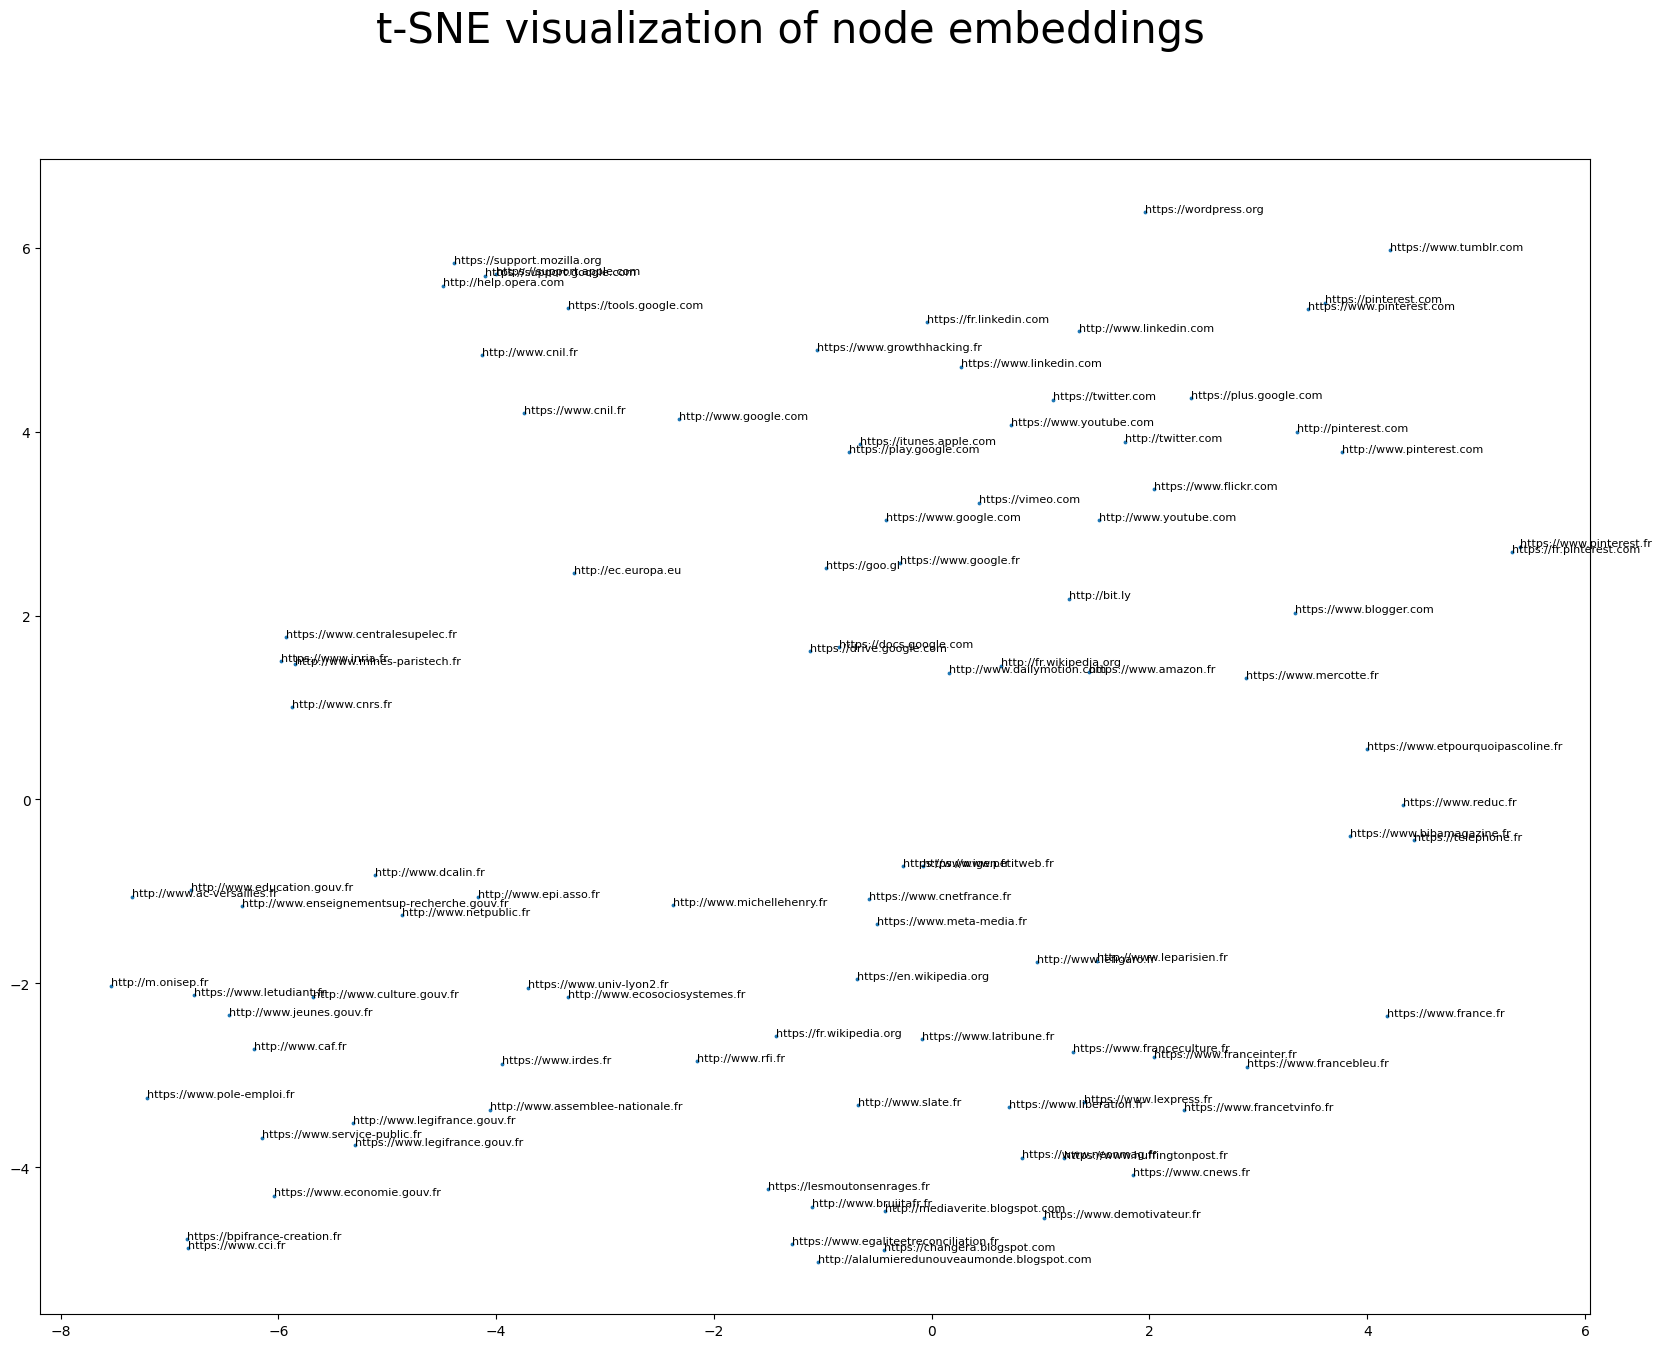

In [ ]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Loads the web graph
G = nx.read_weighted_edgelist('./data/web_sample.edgelist', delimiter=' ', create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


############## Task 3
# Extracts a set of random walks from the web graph and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20

##################
# your code here #

model = deepwalk(G, n_walks, walk_length, n_dim)

##################

############## Task 4
# Visualizes the representations of the 100 nodes that appear most frequently in the generated walks
def visualize(model, n, dim):

    nodes = model.wv.index_to_key[:n] # your code here
    DeepWalk_embeddings = np.empty(shape=(n, dim))

    ##################
    # your code here #

    for i in range(len(nodes)):
        DeepWalk_embeddings[i] = model.wv[nodes[i]]

    ##################


    my_pca = PCA(n_components=10)
    my_tsne = TSNE(n_components=2)

    vecs_pca = my_pca.fit_transform(DeepWalk_embeddings)
    vecs_tsne = my_tsne.fit_transform(vecs_pca)

    fig, ax = plt.subplots()
    ax.scatter(vecs_tsne[:,0], vecs_tsne[:,1],s=3)
    for x, y, node in zip(vecs_tsne[:,0] , vecs_tsne[:,1], nodes):
        ax.annotate(node, xy=(x, y), size=8)
    fig.suptitle('t-SNE visualization of node embeddings',fontsize=30)
    fig.set_size_inches(20,15)
    plt.savefig('embeddings.pdf')
    plt.show()


visualize(model, 100, n_dim)

## node_classification.py

Number of nodes: 34
Number of edges: 78


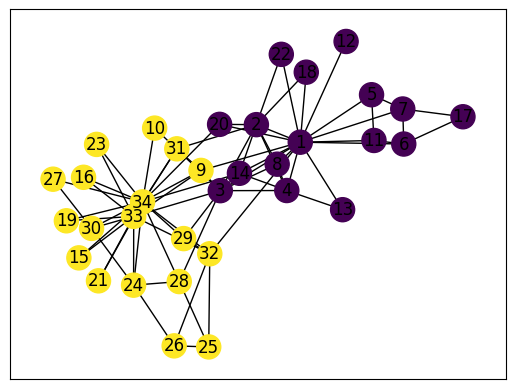

Generating walks
Training word2vec
Classification accuracy (DeepWalk): 1.0
Classification accuracy (spectral): 0.8571428571428571


In [ ]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics import accuracy_score


# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)


############## Task 5
# Visualizes the karate network

##################
# your code here #
import matplotlib.pyplot as plt

nx.draw_networkx(G, node_color=y)
plt.show()

##################


############## Task 6
# Extracts a set of random walks from the karate network and feeds them to the Skipgram model
n_dim = 128
n_walks = 10
walk_length = 20
model = deepwalk(G, n_walks, walk_length, n_dim) # your code here

embeddings = np.zeros((n, n_dim))
for i, node in enumerate(G.nodes()):
    embeddings[i,:] = model.wv[str(node)]

idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

X_train = embeddings[idx_train,:]
X_test = embeddings[idx_test,:]

y_train = y[idx_train]
y_test = y[idx_test]


############## Task 7
# Trains a logistic regression classifier and use it to make predictions


##################
# your code here #

clf = LogisticRegression().fit(X_train, y_train)
y_predict = clf.predict(X_test)
print('Classification accuracy (DeepWalk):', accuracy_score(y_test, y_predict))

##################


############## Task 8
# Generates spectral embeddings

##################
# your code here #

A = nx.adjacency_matrix(G)      # Adjacency matrix
I = eye(G.number_of_nodes())    # Identity matrix
D_inv = diags([1/G.degree(node) for node in G.nodes()]) # Inverse of diagonal degree matrix
L_rw = I - (D_inv @ A)          # Random walk normalized Laplacian matrix

_, eig_vecs = eigs(L_rw, k=2, which='SR')
spectral_embeddings = eig_vecs.real

X_spectral_train = spectral_embeddings[idx_train,:]
X_spectral_test = spectral_embeddings[idx_test,:]

clf_spectral = LogisticRegression().fit(X_spectral_train, y_train)
y_spectral_predict = clf_spectral.predict(X_spectral_test)
print('Classification accuracy (spectral):', accuracy_score(y_test, y_spectral_predict))

##################

# Part 2

## utils.py

In [ ]:
import scipy.sparse as sp
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

def normalize_adjacency(A):
    ############## Task 9

    ##################
    # your code here #

    A_tilde = A + sp.identity(A.shape[0])
    D_tilde = sp.diags(np.sum(A_tilde.toarray(), axis=1))
    A_normalized = D_tilde.power(-0.5) @ A_tilde @ D_tilde.power(-0.5)

    ##################

    return A_normalized


def load_cora():
    idx_features_labels = np.genfromtxt("./data/cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)

    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("./data/cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

## models.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, cora=False):
        ############## Tasks 10 and 13

        ##################
        # your code here #

        z0 = self.relu(torch.mm(adj, self.fc1(x_in)))
        z0 = self.dropout(z0)
        z1 = self.relu(torch.mm(adj, self.fc2(z0)))
        x = self.fc3(z1)

        if cora:
            return F.log_softmax(x, dim=1), z1

        ##################


        return F.log_softmax(x, dim=1)

## gnn_karate.py

In [ ]:
import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score


# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
# features = np.eye(n) # Generates node features
features = np.ones((n,n))

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)



# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()

34
78


<ipython-input-4-37c26582d630>:52: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


Epoch: 001 loss_train: 0.6933 acc_train: 0.5556 time: 0.1386s
Epoch: 002 loss_train: 0.6947 acc_train: 0.5556 time: 0.0028s
Epoch: 003 loss_train: 0.6891 acc_train: 0.5556 time: 0.0028s
Epoch: 004 loss_train: 0.7001 acc_train: 0.5556 time: 0.0027s
Epoch: 005 loss_train: 0.6801 acc_train: 0.5926 time: 0.0026s
Epoch: 006 loss_train: 0.6881 acc_train: 0.6667 time: 0.0025s
Epoch: 007 loss_train: 0.6904 acc_train: 0.5556 time: 0.0028s
Epoch: 008 loss_train: 0.6864 acc_train: 0.5556 time: 0.0026s
Epoch: 009 loss_train: 0.6917 acc_train: 0.5556 time: 0.0026s
Epoch: 010 loss_train: 0.6768 acc_train: 0.5556 time: 0.0028s
Epoch: 011 loss_train: 0.6896 acc_train: 0.5556 time: 0.0026s
Epoch: 012 loss_train: 0.6787 acc_train: 0.5926 time: 0.0028s
Epoch: 013 loss_train: 0.6727 acc_train: 0.6296 time: 0.0025s
Epoch: 014 loss_train: 0.6816 acc_train: 0.5556 time: 0.0027s
Epoch: 015 loss_train: 0.6662 acc_train: 0.6296 time: 0.0026s
Epoch: 016 loss_train: 0.6582 acc_train: 0.5556 time: 0.0032s
Epoch: 0

## gnn_cora.py

Dataset has 2708 nodes, 5429 edges, 1433 features.
Epoch: 001 loss_train: 1.9275 acc_train: 0.3030 loss_val: 1.9184 acc_val: 0.2804 time: 0.0459s
Epoch: 002 loss_train: 1.9144 acc_train: 0.3042 loss_val: 1.9075 acc_val: 0.2804 time: 0.0401s
Epoch: 003 loss_train: 1.9017 acc_train: 0.3042 loss_val: 1.8959 acc_val: 0.2804 time: 0.0381s
Epoch: 004 loss_train: 1.8881 acc_train: 0.3042 loss_val: 1.8843 acc_val: 0.2804 time: 0.0413s
Epoch: 005 loss_train: 1.8741 acc_train: 0.3042 loss_val: 1.8738 acc_val: 0.2804 time: 0.0390s
Epoch: 006 loss_train: 1.8602 acc_train: 0.3042 loss_val: 1.8624 acc_val: 0.2804 time: 0.0389s
Epoch: 007 loss_train: 1.8469 acc_train: 0.3042 loss_val: 1.8510 acc_val: 0.2804 time: 0.0406s
Epoch: 008 loss_train: 1.8326 acc_train: 0.3042 loss_val: 1.8405 acc_val: 0.2804 time: 0.0389s
Epoch: 009 loss_train: 1.8176 acc_train: 0.3042 loss_val: 1.8320 acc_val: 0.2804 time: 0.0408s
Epoch: 010 loss_train: 1.8065 acc_train: 0.3042 loss_val: 1.8244 acc_val: 0.2804 time: 0.0409s

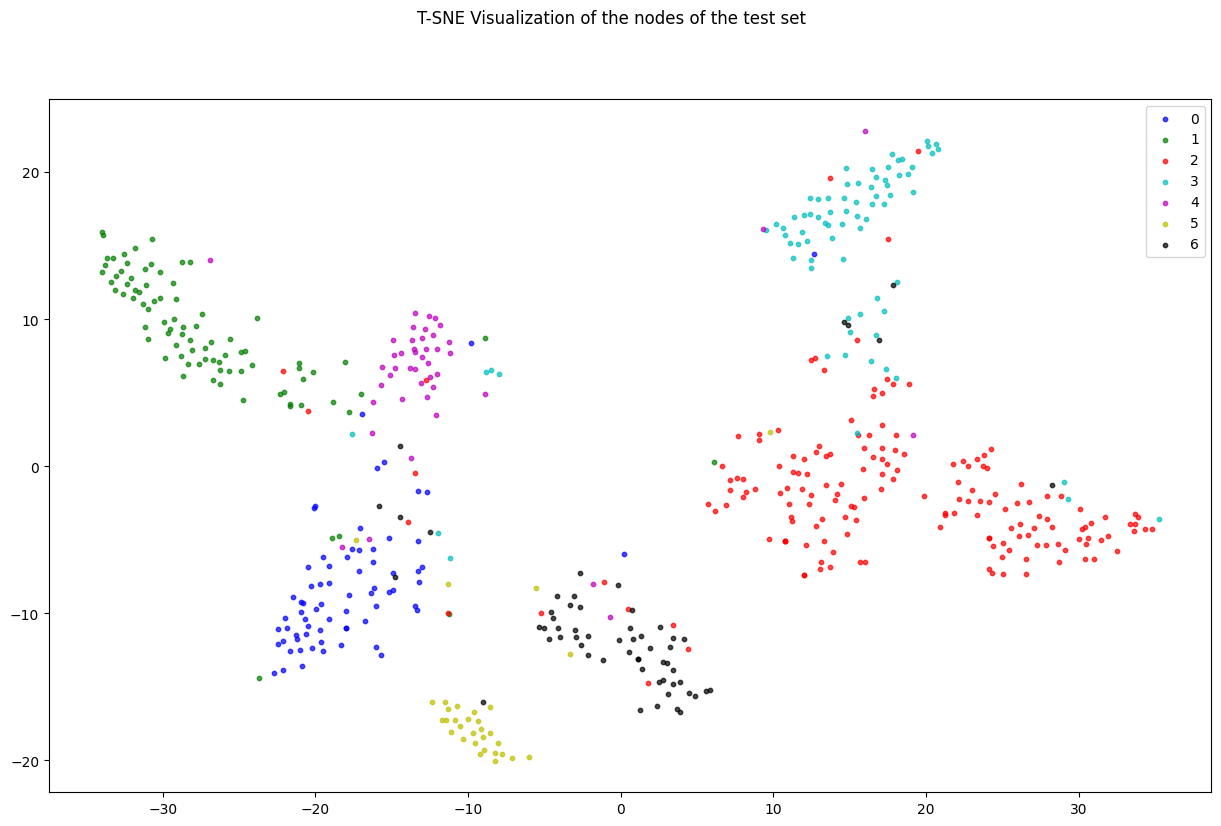

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj, cora=True)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()


    model.eval()
    output,_ = model(features, adj, cora=True)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj, cora=True)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())

    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()



############## Task 13
# Transforms torch tensor to numpy matrix

##################
# your code here #

embeddings_test = embeddings_test.detach().cpu().numpy()

##################


# Projects the emerging representations to two dimensions using t-SNE

##################
# your code here #

embeddings_test_2d = TSNE(n_components=2).fit_transform(embeddings_test)

##################


labels = class_labels[idx_test]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0],
               embeddings_test_2d[idxs,1],
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()